# Neural Networks

In [1]:
import time
import os
import pprint
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tqdm.notebook as tq
import utils
import Datasets, Models
from pydub import AudioSegment
from tkinter import Tcl # file sorting by name

# Train and Test functions

In [2]:
def test(model, validation_dataset, Y_validation, RGB = False, is_ensamble = False, normalized_cm = False):
    # Stop parameters learning
    model.eval()

    validation_loader = torch.utils.data.DataLoader(validation_dataset)

    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8, 8), dtype=int)
    i=0
    
    with torch.no_grad():
        for sample, label in validation_loader:
            if(i%100==0):
                print(i,"/",(len(validation_dataset)))
            
            if(RGB==False and is_ensamble == False):
                inputs=inputs.unsqueeze(1)
                
            # Predict label
            output = model(sample[0],sample[1])
           
            
            # Compute loss
            loss = criterion(output, label)
            total_loss += loss.item()

            max_index = torch.argmax(output).item()  # The index with maximum probability

            confusion_matrix[label][max_index] += 1

            correct += (max_index == label)
            i+=1

    fig, ax = plt.subplots(dpi=500)
    if(normalized_cm == True):
        confusion_matrix = (confusion_matrix*8)/len(Y_validation)
    cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm.plot(ax=ax)
    accuracy = 100 * correct / len(Y_validation)
    average_loss = total_loss / len(Y_validation)

    model.train()
    return accuracy, average_loss, confusion_matrix

In [18]:
def vote_test(model, validation_dataset, Y_validation, RGB = False, is_ensamble = False, normalized_cm=False):
    #Stop parameters learning
    model.eval()
    
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20)

    # Crea una funzione di perdita con pesi
    criterion = nn.CrossEntropyLoss()
    
    #criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0
    confusion_matrix = np.zeros((8,8 ), dtype=int)

    correct_maj=0
    i = 0
    
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            if(i%100==0):
                print(i*20,"/",(len(validation_dataset)))
            if(RGB==False and is_ensamble == False):
                inputs=inputs.unsqueeze(1)
            
            #predict label
            if(is_ensamble==True):
                outputs = model(inputs[0],inputs[1])
            else:
                outputs = model(inputs)
            #print("Outputs:",outputs,"size:",outputs.size())
            #compute loss
            voting=outputs.mean(dim=0)
            voting=voting.unsqueeze(0)
            label=labels[0].unsqueeze(0)
            loss = criterion(voting, label)
            total_loss += loss.item()
            #print("Voting:",voting,"size:",voting.size())
            predicted= torch.argmax(voting)
            #print("winning class",predicted)
            correct += (predicted == labels[0])
            confusion_matrix[label][predicted]+=1
            
            votes=[0,0,0,0,0,0,0,0]
            i+=1
       
            
        
    if(normalized_cm == True):
        confusion_matrix = (confusion_matrix*8)/(len(Y_validation)/20)
    cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    fig, ax = plt.subplots(dpi=500)
    cm.plot(ax=ax)
    cm.plot()    
    accuracy = 100*correct / (len(Y_validation)/20) 
    average_loss = total_loss / (len(Y_validation)/20)

    model.train()
    return accuracy, average_loss, confusion_matrix

In [19]:
def train(model, dataset, batch_size, num_epochs, learning_rate, verbose = False,reg=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    val_loss_list=[]
    val_acc_list=[]
    train_loss_list=[]
    train_acc_list=[]
    counted_labels=[0,0,0,0,0,0,0,0]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    criterion = nn.CrossEntropyLoss()

    if not isinstance(dataset, Dataset):
        raise ValueError("The dataset parameter should be an instance of torch.utils.data.Dataset.")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_accuracy = 0.0
        #initialize correctly predicted samples
        
        # Initialize the progress bar
        progress_bar = tq.tqdm(total=num_batches, unit="batch")
    
        # Initialize the progress bar description
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        for batch_idx, batch in enumerate(data_loader):
            
            correct = 0 # reset train accuracy each batch
            
            inputs,labels = batch[0],batch[1]
            if(verbose == True):
                print("\ninputs shape:",inputs.size(),", dtype:",inputs.dtype," content: ",inputs)
                print("min value:",torch.min(inputs))
                print("max value:",torch.max(inputs))
                print("\nlabels shape:",labels.size(),",dtype:",labels.dtype,", content: ",labels)
          
            
            # Extract the inputs and targets
            optimizer.zero_grad()
            outputs = model(inputs[0],inputs[1])
            
            if(verbose == True):
                print("\noutputs size:",outputs.size(),"content:",outputs)
                print("List of labels until now:",counted_labels)

            loss = criterion(outputs, labels) #labels need to be a vector of class indexes (0-7) of dim (batch_size)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            #calculate train accuracy
            for index, output in enumerate(outputs):
                max_index = torch.argmax(output).item() #the index with maximum probability
                counted_labels[labels[index].item()]+=1
                if(labels[index].item() == max_index):
                    correct += 1
            
                if(verbose==True):
                    print("considering output at index {}:".format(index,output))
                    print("max output index = {}",max_index)
                    if(labels[index].item() == max_index):
                        print("correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))
                    else:
                        print("NOT correct! in fact labels[index] = {}, max_index = {}".format(labels[index].item(),max_index))

            
            accuracy = 100 * correct / batch_size
            running_accuracy += accuracy #epoch running_accuracy
            
            # Update the progress bar description and calculate bps
            #progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})
            average_accuracy = running_accuracy / (batch_idx + 1)
            average_loss = running_loss / (batch_idx + 1)
            progress_bar.set_postfix({"avg_loss": average_loss, "acc": accuracy, "avg_acc": average_accuracy})

            # Update the progress bar
            progress_bar.update(1)
            # Evaluate the model on the validation dataset
        
        #calculate train loss and accuracy
        average_loss = running_loss / len(data_loader)
        average_accuracy = running_accuracy / len(data_loader)
        train_loss_list.append(average_loss)
        train_acc_list.append(average_accuracy)
        
        #calculate validation loss and accuracy
        val_acc, val_loss = test(model, validation_dataset, Y_validation)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {average_loss:.4f}. Train Accuracy: {average_accuracy} Val Loss: {val_loss} Val Accuracy: {val_acc}")
        progress_bar.close()
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

# Load STFT Dataset

### Dictionary creation for the classes

We want a dictionary indicating a numbeer for each genre:

{0: 'Hip-Hop', 1: 'Pop', 2: 'Folk', 3: 'Rock', 4: 'Experimental', 5: 'International', 6: 'Electronic', 7: 'Instrumental'}

### Creation of the labels vector

In [5]:
folder_path="data/fma_small_stft_transposed_22050_overlapped"
Y_train, Y_validation, Y_test = Datasets.create_dataset_splitted(folder_path)

train_folder: data/fma_small_stft_transposed_22050_overlapped/train
validation_folder: data/fma_small_stft_transposed_22050_overlapped/validation
test_folder: data/fma_small_stft_transposed_22050_overlapped/test 

audio directory:  ./data/fma_small/
Loading tracks.csv...
small dataset shape: (8000, 52)
Track.csv: 6400 training samples, 800 validation samples, 800 test samples

there are 8 unique genres
Dictionary of genres created: {'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Rock': 3, 'Experimental': 4, 'International': 5, 'Electronic': 6, 'Instrumental': 7}
labels length: 127940
labels length: 16000
labels length: 16000


# Dataset Class

Class to load the STFT from files. Each file has a (128,513) matrix containing the STFT of a 3 seconds audio clip.

In [6]:
folder_path="data/fma_small_stft_transposed_22050_overlapped"

stft_train_folder = os.path.join(folder_path,'train') # concatenate train folder to path
stft_validation_folder = os.path.join(folder_path,'validation') # concatenate train folder to path
stft_test_folder = os.path.join(folder_path,'test') # concatenate train folder to path

stft_train_file_paths, _ = Datasets.get_sorted_file_paths(stft_train_folder)
stft_train_dataset = Datasets.DatasetSTFT(stft_train_file_paths, Y_train)
print("len of train dataset: ",len(stft_train_dataset))

stft_validation_file_paths, _ = Datasets.get_sorted_file_paths(stft_validation_folder)
stft_validation_dataset = Datasets.DatasetSTFT(stft_validation_file_paths, Y_validation)
print("len of validation dataset: ",len(stft_validation_dataset))

stft_test_file_paths, _ = Datasets.get_sorted_file_paths(stft_test_folder)
stft_test_dataset = Datasets.DatasetSTFT(stft_test_file_paths, Y_test)
print("len of test dataset: ",len(stft_test_dataset))

len of train dataset:  127940
len of validation dataset:  16000
len of test dataset:  16000


# Data normalization
We will use Z-Score to normalize the training, validation and test set by calculating the mean and the std deviation on the training set.

In [7]:
save_filename = './data/fma_small_stft_transposed_22050_overlapped/train_mean'
std_save_filename = './data/fma_small_stft_transposed_22050_overlapped/train_std_deviation'

## Calculation of mean and standard deviation (Long)

In [ ]:
batch_size=1
total_n_batches = len(stft_train_dataset)/batch_size
train_loader = torch.utils.data.DataLoader(stft_train_dataset, batch_size=batch_size)
current_sum=0

#iter all the training set by batches and calculate the sum of all the sample values (513*128 values for each sample)
for batch_idx, batch in enumerate(train_loader):
    #print("batch",batch_idx,"/",total_n_batches,"current_sum:",current_sum)
    inputs = batch[0]
    labels = batch[1]
    #print("inputs: shape:",inputs.shape,"content:",inputs)
    #print("labels:",labels)
    for sample in inputs:
        #print("sample: shape",sample.shape,"content:",sample)
        current_sum += torch.sum(sample)
        #print("current_sum:",current_sum)
print("final sum:",current_sum)



In [ ]:
mean = current_sum/(len(stft_train_dataset)*513*128) #divide the sum for the total number of values considerated
print("mean of training set:",mean)

print("Saving the mean in file:",save_filename) 
np.save(save_filename,mean)

In [ ]:
#now let's calculate the standard deviation (squared root of the variance)

batch_size=1
total_n_batches = len(stft_train_dataset)/batch_size
train_loader = torch.utils.data.DataLoader(stft_train_dataset, batch_size=batch_size)
current_sum_of_squares = 0

for batch_idx, batch in enumerate(train_loader):
    #print("batch",batch_idx,"/",total_n_batches,"current_sum_of_squares:",current_sum_of_squares)
    inputs = batch[0]
    labels = batch[1]
    #print("inputs: shape:",inputs.shape,"content:",inputs)
    #print("labels:",labels)
    for sample in inputs:
        #print("sample shape",sample.shape)
        for row in sample:
            #print("row shape:",row.shape)
            for elem in row:
                #print("elem: shape",elem.shape,"content:",elem)
                difference = elem - mean
                difference_squared = difference**2
                current_sum_of_squares += difference_squared
                #print("current_sum:",current_sum)
print("final sum of squares:",current_sum_of_squares)


In [ ]:
import math

variance = current_sum_of_squares/((len(stft_train_dataset) * 513 * 128)-1)
std_deviation = math.sqrt(variance)

print("variance:",variance)
print("std_deviation:",std_deviation)

print("Saving the std_deviation in file:",std_save_filename) 
np.save(std_save_filename,std_deviation)

## Load calculated mean and std deviation from file

In [8]:
loaded_mean = np.load(save_filename+'.npy')
print("loaded mean:",loaded_mean)

loaded_std = np.load(std_save_filename+'.npy')
print("loaded std:",loaded_std)

loaded mean: 1.0629134
loaded std: 3.0528938510507846


## Create the normalized dataset

In [9]:
from torchvision import transforms

batch_size = 1

transform = transforms.Compose([
    transforms.Normalize(mean= loaded_mean, std= loaded_std)
])

stft_train_dataset = Datasets.DatasetSTFT(stft_train_file_paths, Y_train,  transform = transform)
stft_validation_dataset = Datasets.DatasetSTFT(stft_validation_file_paths, Y_validation,  transform = transform)
stft_test_dataset = Datasets.DatasetSTFT(stft_test_file_paths, Y_test,  transform = transform)

## Plot a STFT spectrogram

In [ ]:
batch_size=1
train_loader = torch.utils.data.DataLoader(stft_train_dataset, batch_size=batch_size)

#iter all the training set by batches and calculate the sum of all the sample values (513*128 values for each sample)
for batch_idx, batch in enumerate(train_loader):
    inputs = batch[0]
    labels = batch[1]
    print("inputs: shape:",inputs.shape,"content:",inputs)
    print("labels:",labels)
    for sample in inputs:
        print("sample: shape",sample.shape,"content:",sample)
        fig, ax = plt.subplots(dpi=500)
        img = librosa.display.specshow(librosa.amplitude_to_db(sample.T,ref=np.max), y_axis='log', x_axis='time', ax=ax)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')

        fig.colorbar(img, ax=ax, format="%+2.0f dB")
    if(batch_idx==4):
        break


# STFT Models

### NNet1

In [ ]:
model_NNet1 = Models.NNet1()
summary(model_NNet1, (1, 128, 513))

### NNet2

In [ ]:
model_NNet2 = Models.NNet2()
summary(model_NNet2, (1, 128, 513))

### NNet1_Small

In [ ]:
model_NNet1_Small = Models.NNet1_Small()
summary(model_NNet1_Small, (1, 128, 513))

# Hyperparameters

In [ ]:
BATCH_SIZE=32
EPOCHS=10

learning_rate_list = [0.001,0.0001,0.00001]
reg_list=[0.001,0.0001,0.00001]

# Train function

# Grid Search on NNet1_Small

Here we show an example of code for performing grid search on hyperparameters. In this case we are doing it for NNet1_Raw.

In [ ]:
#TODO: Add batch_size optimization loop
save_directory="./results/NNet1_Small/"


for i in learning_rate_list:
    for j in reg_list:
        if(j!=1e-5 and j!=1e-6):
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"0"+str(j).split(".")[1]
        elif(j==1e-5):
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"00001"
        else:
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"000001"
        print(filename)
        model = Models.NNet1_Small()
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, stft_train_dataset,stft_validation_dataset, batch_size=128, num_epochs=10, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        print("Loss:",val_loss_list)
        print("Accuracy:",val_acc_list)
        save_values=[val_loss_list,val_acc_list]
        np.savetxt(filename,save_values)

# Normalization of raw audio

We calculate mean and std deviation

In [ ]:
mean_save_filename_raw = './data/fma_small_raw_array_22050_overlapped/train_mean'
std_save_filename_raw = './data/fma_small_raw_array_22050_overlapped/train_std_deviation'

# Calculation of mean raw (Long)

In [ ]:
raw_train_dataset = Datasets.DatasetRaw(raw_file_paths_train, Y_train)
batch_size=1
total_n_batches = len(raw_train_dataset)/batch_size
train_loader = torch.utils.data.DataLoader(raw_train_dataset, batch_size=batch_size)
current_sum=0

#iter all the training set by batches and calculate the sum of all the sample values (513*128 values for each sample)
for batch_idx, batch in enumerate(train_loader):
    if(batch_idx%1000==0):
        print("batch",batch_idx,"/",total_n_batches,"(",round((batch_idx/len(train_dataset)*100)),"%), current_sum:",current_sum)
    
    inputs = batch[0]
    labels = batch[1]
    #print("inputs: shape:",inputs.shape,"content:",inputs)
    #print("labels:",labels)
    for sample in inputs:
        #print("sample: shape",sample.shape,"content:",sample)
        current_sum += torch.sum(sample)
       
        #print("type of current_sum:",current_sum.dtype)
        #print("current_sum:",current_sum)
print("final sum:",current_sum)

In [ ]:
print("current_sum",current_sum)
mean_raw = current_sum/(len(raw_train_dataset)*66150) #divide the sum for the total number of values considerated
print("mean of training set:",mean_raw)

print("Saving the mean in file:",mean_save_filename_raw) 
np.save(mean_save_filename_raw,mean_raw)

# Calculation of std deviation raw (Long)

In [ ]:
#now let's calculate the standard deviation (squared root of the variance)

batch_size=1
total_n_batches = len(raw_train_dataset)/batch_size
train_loader = torch.utils.data.DataLoader(raw_train_dataset, batch_size=batch_size)
current_sum_of_squares = 0

for batch_idx, batch in enumerate(train_loader):
    if(batch_idx%1000==0):
        print("batch",batch_idx,"/",total_n_batches,round((batch_idx/len(train_dataset)*100)),"%, current_sum_of_squares:",current_sum_of_squares)
    inputs = batch[0]
    labels = batch[1]
    #print("inputs: shape:",inputs.shape,"content:\n",inputs)
    #print("labels:",labels)
    for elem in inputs:
        elem = elem.double() #convert to float64 for precise calculations
        #print("elem: shape",elem.shape,"content:\n",elem)
        difference = elem - mean_raw
        #print("difference: shape:",difference.shape,"content:\n", difference)
        difference_squared = difference**2
        #print("difference_squared: shape:",difference_squared.shape,"content:\n", difference_squared)
        current_sum_of_squares += torch.sum(difference_squared)
        #print("current_sum_of_squares:",current_sum_of_squares)
print("final sum of squares:",current_sum_of_squares)

In [ ]:
import math

variance_raw = current_sum_of_squares/((len(train_dataset)*66150)-1)
std_deviation_raw = math.sqrt(variance)

print("variance raw:",variance)
print("std_deviation_raw:",std_deviation_raw)

print("Saving the std_deviation_raw in file:",std_save_filename_raw) 
np.save(std_save_filename_raw,std_deviation_raw)

# Load mean and std from file (fast)

In [ ]:
loaded_mean_raw = np.load(mean_save_filename_raw+'.npy')
print("loaded mean:",loaded_mean_raw)

loaded_std_raw = np.load(std_save_filename_raw+'.npy')
print("loaded std:",loaded_std_raw)

## Create dataset for raw audio

The labels are the same as the STFT dataset (in the same order).

In [ ]:
raw_folder_path="data/fma_small_raw_array_22050_overlapped"
    
Y_train, Y_validation, Y_test = Datasets.create_dataset_splitted(raw_folder_path)
raw_train_folder = os.path.join(raw_folder_path,'train') # concatenate train folder to path
raw_validation_folder = os.path.join(raw_folder_path,'validation') # concatenate train folder to path
raw_test_folder = os.path.join(raw_folder_path,'test') # concatenate train folder to path

raw_train_file_paths, _ = Datasets.get_sorted_file_paths(raw_train_folder)
raw_train_dataset = Datasets.DatasetRaw(raw_train_file_paths, Y_train)
print("len of train dataset: ",len(train_dataset))

raw_validation_file_paths, _ = Datasets.get_sorted_file_paths(raw_validation_folder)
raw_validation_dataset = Datasets.DatasetRaw(raw_validation_file_paths, Y_validation)
print("len of validation dataset: ",len(raw_validation_dataset))

raw_test_file_paths, _ = Datasets.get_sorted_file_paths(raw_test_folder)
raw_test_dataset = Datasets.DatasetRaw(raw_test_file_paths, Y_test)
print("len of test dataset: ",len(raw_test_dataset))

# Raw Model

In [ ]:
RawModel=Models.NNet_Raw()
summary(RawModel, (1,66150))
print(MyModel)

## Plot raw sample

In [ ]:
from torch import Tensor
batch_size=1
train_loader = torch.utils.data.DataLoader(raw_train_dataset, batch_size=batch_size)

#iter all the training set by batches and calculate the sum of all the sample values (513*128 values for each sample)
for batch_idx, batch in enumerate(train_loader):
    inputs = batch[0]
    labels = batch[1]
    print("inputs: shape:",inputs.shape,"content:",inputs)
    print("labels:",labels)
    for sample in inputs:
        print("sample: shape",sample.shape,"content:",sample)
        fig, ax = plt.subplots(dpi=300)
        librosa.display.waveshow(Tensor.numpy(sample.float()), sr=22150, ax=ax)
        ax.set(title='Envelope view, mono')
        ax.set_ylabel('Amplitude')
        ax.set_xlabel('Time (s)')
        ax.label_outer()
    if(batch_idx==4):
        break

# Grid Search for NNet_Raw

In [ ]:
#TODO: Add batch_size optimization loop
save_directory="./results/NNet_Raw/"

lr_list= [ 0.0001]
r_list=[0.0001]

for i in lr_list:
    for j in r_list:
        if(j!=1e-5 and j!=1e-6):
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"0"+str(j).split(".")[1]
        elif(j==1e-5):
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"00001"
        else:
            filename=save_directory+"lr_"+"0"+str(i).split(".")[1]+"_reg_"+"000001"
        print(filename)
        model = Models.NNet_Raw()
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, train_dataset, batch_size=128, num_epochs=10, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        print("Loss:",val_loss_list)
        print("Accuracy:",val_acc_list)
        save_values=[val_loss_list,val_acc_list]
        np.savetxt(filename,save_values)

# Ensamble of NNet1_Small and NNet_Raw

In [ ]:
stft_train_file_paths, _ = Datasets.get_sorted_file_paths(stft_train_folder)
raw_train_file_paths, _ = Datasets.get_sorted_file_paths(raw_train_folder)
ens_train_dataset = Datasets.DatasetEnsemble(stft_train_file_paths,raw_train_file_paths, Y_train)
print("len of train dataset: ",len(train_dataset))

stft_validation_file_paths, _ = Datasets.get_sorted_file_paths(stft_validation_folder)
raw_validation_file_paths, _ = Datasets.get_sorted_file_paths(raw_validation_folder)
ens_validation_dataset = Datasets.DatasetEnsemble(stft_validation_file_paths,raw_validation_file_paths, Y_validation)
print("len of validation dataset: ",len(validation_dataset))

stft_test_file_paths, _ = Datasets.get_sorted_file_paths(stft_test_folder)
raw_test_file_paths, _ = Datasets.get_sorted_file_paths(raw_test_folder)
ens_test_dataset = Datasets.DatasetEnsemble(stft_test_file_paths,raw_test_file_paths, Y_test)
print("len of test dataset: ",len(test_dataset))

In [ ]:
#With the following parameter it can be established if the ensamble should use pre-trained weights or not
weights=True
model_ensamble_weights=Models.Ensemble(load_weights=weights)

In [ ]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model_ensamble_weights, ens_train_dataset, batch_size=64, num_epochs=10, learning_rate=0.001,verbose=False, RGB=True)

# NN on echonest features 

As you can see below, unfortunately we cannot perform a train using echonest features (danceability, tempo, acousticness, ...) because there are only ►1300 tracks with echonest features which are not NaN.

In [ ]:
print("opening csvs...")

tracks = utils.load('data/fma_metadata/tracks.csv')

echonest = utils.load('data/fma_metadata/echonest.csv')
echonest = echonest['echonest', 'audio_features']
small = tracks[tracks['set', 'subset'] <= 'small']

print("small dataset shape:",small.shape)
print("echonest csv shape (only audio features):",echonest.shape)

In [ ]:
#select small dataset from echonest csv

track_ids = small.index.values.tolist()
print("Track ids shape:",len(track_ids),"content:",track_ids[:10],"...")
echonest_small = pd.DataFrame(echonest,index=track_ids)

ipd.display(echonest_small)

In [ ]:
X_train_echonest = echonest_small.to_numpy(dtype=np.float16)
print("X_train_echonest: shape:",X_train_echonest.shape)

nan_rows = np.argwhere(np.isnan(X_train_echonest).all(axis=1))

print("There are",len(nan_rows),"rows containing NaN only as data")
#nan_rows = nan_rows.squeeze()
#for i in nan_rows:
#    print("row:",i,":",X_train_echonest[i])

# ResNet
We try to use transfer learning using a ResNet18 by torch

In [ ]:
#Choose the model to use by changing the value of the following variable
fine_tuning=True

ResNetModel=Models.Model_ResNet18(pretrained=fine_tuning)
summary(ResNetModel, (3,128,513))
print(ResNetModel)

In [ ]:
transform_ResNet18 = transforms.Compose([
    transforms.Normalize(mean= [loaded_mean,loaded_mean,loaded_mean], std=[loaded_std,loaded_std,loaded_std]) #our values
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #ResNet18 specific values
])

rgb_train_dataset = Datasets.DatasetRGB(stft_train_file_paths, Y_train,  transform = transform)
rgb_validation_dataset = Datasets.DatasetRGB(stft_validation_file_paths, Y_validation,  transform = transform)
rgb_test_dataset = Datasets.DatasetRGB(stft_test_file_paths, Y_test,  transform = transform)

train_data_loader = DataLoader(rgb_train_dataset, batch_size = 10, shuffle=True)



# Training ResNet model

In [ ]:
#train the model
train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(ResNetModel, rgb_train_dataset,rgb_validation_dataset, batch_size=64, num_epochs=10, learning_rate=0.001,verbose=False, RGB=True)

# Example of "Best Model" Training

In [ ]:
save_directory="./best_models/"

learning_rate_list = [0.001]
reg_list=[0.0001]
epochs=9

for i in learning_rate_list:
    for j in reg_list:
        filename=save_directory+"results/NNet1"        
        print(filename)
        model = Models.NNet1()
        train_loss_list, train_acc_list, val_loss_list, val_acc_list =train(model, stft_train_dataset,stft_validation_dataset, batch_size=64, num_epochs=epochs, learning_rate=i, reg=j)
        print("Trained with learning rate=",i," and with regularization term=",j)
        torch.save(model.state_dict(), save_directory+"best_models/NNet_Raw")

# Example of Models Testing

Model loaded: testing...
0 / 16000
2000 / 16000
4000 / 16000
6000 / 16000
8000 / 16000
10000 / 16000
12000 / 16000
14000 / 16000


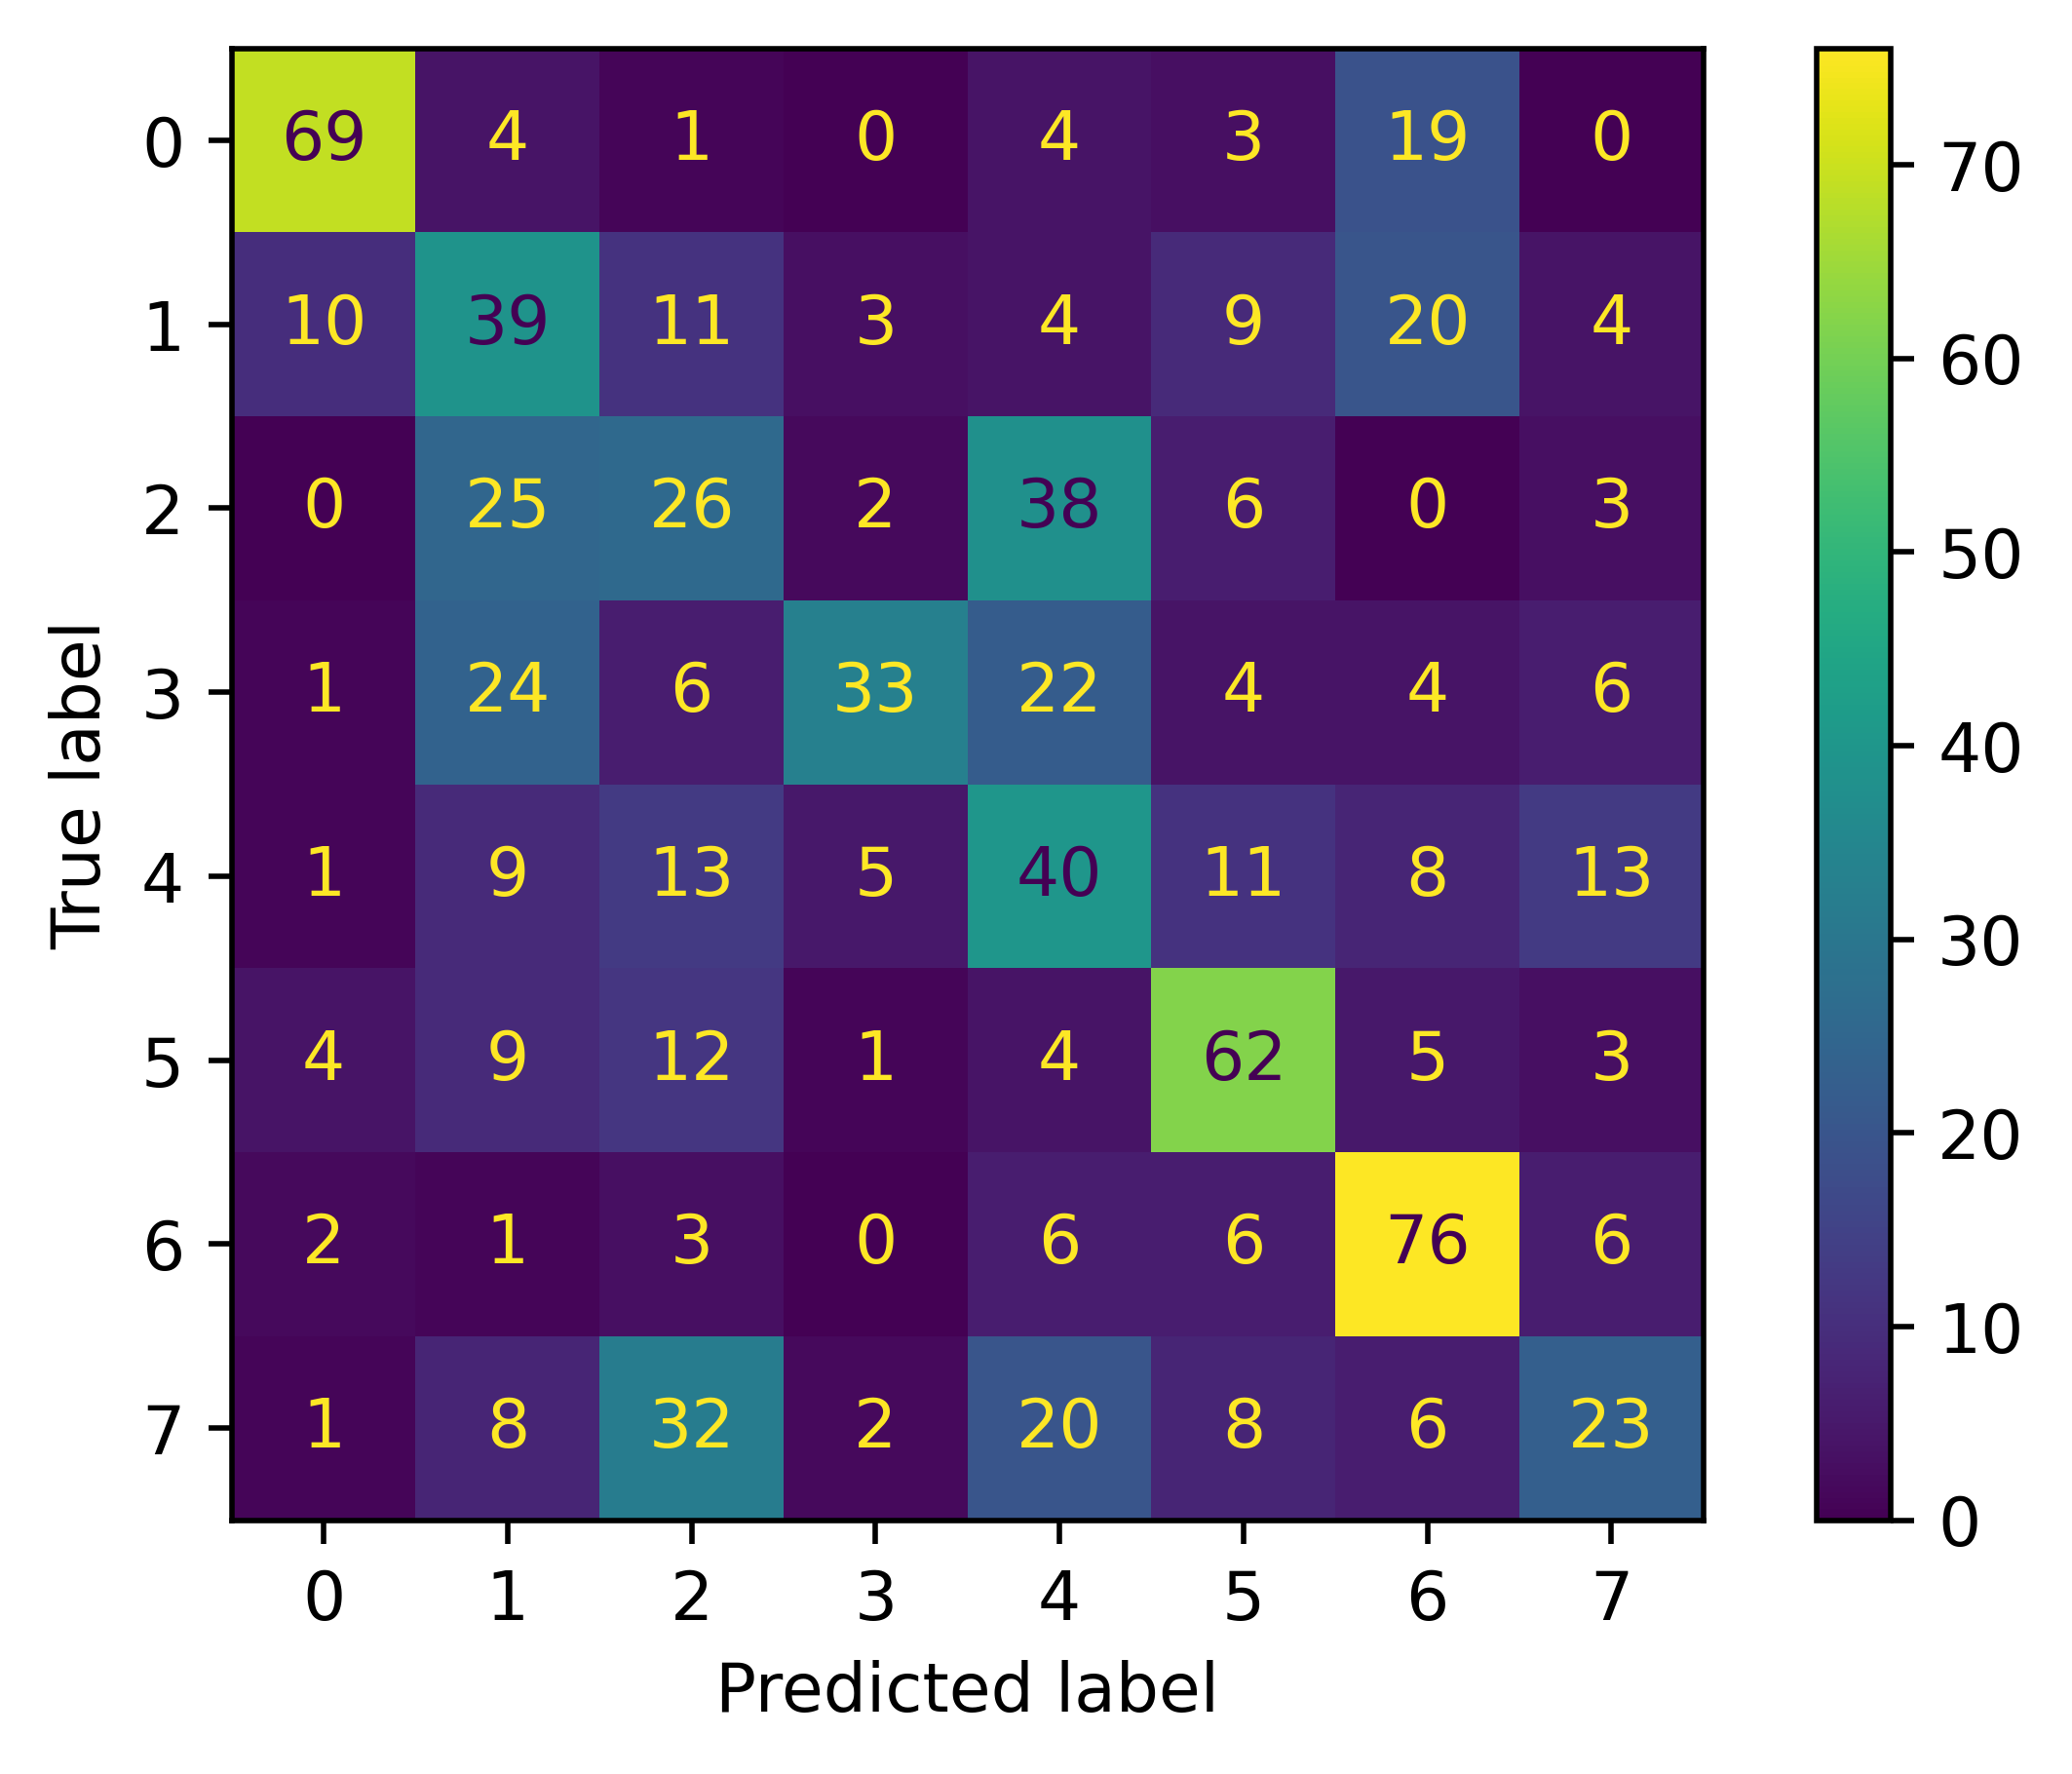

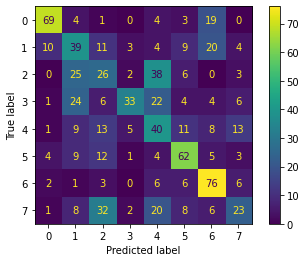

In [20]:
model_path="./best_models/best_models/"
model_name="NNet1"

test_model=Models.NNet1()
test_model.load_state_dict(torch.load(model_path+model_name), strict=False)
print("Model loaded: testing...")
test_results = vote_test(test_model,stft_test_dataset, Y_test, RGB=False, is_ensamble=False, normalized_cm=False)



# Results Loader

In [ ]:
def find_best_value(values,loss):
    if loss==True:
        max_v=100
    else:
        max_v=0
    index=-1
    for i in range(len(values)):
        if loss==True:
            if values[i]<max_v:
                max_v=values[i]
                index=i+1
        else:
            if values[i]>max_v:
                max_v=values[i]
                index=i+1
    return max_v,index
            

In [ ]:
res_directory="./results/"
models=os.listdir(res_directory) 
for i in models:
    print(i)
    best_loss=100
    best_acc=0
    best_loss_ep=0
    best_acc_ep=0
    model_folder=res_directory+i
    trials=os.listdir(model_folder)
    if(len(trials)==0):
        continue
    best_trials=[(best_loss,best_loss_ep),(best_acc,best_acc_ep)]
    best_trials_names=['','']
    for j in trials:
        print(j)
        res=np.loadtxt(model_folder+"/"+j)
        loss,epoch_l=find_best_value(res[0],True)
        accuracy,epoch_a=find_best_value(res[1],False)
        if(loss<best_loss):
            best_trials_names[0]=j
            best_loss=loss
            best_loss_ep=epoch_l
            best_trials[0]=(best_loss,best_loss_ep)
        if(accuracy>best_acc):
            best_trials_names[1]=j
            best_acc=accuracy
            best_acc_ep=epoch_a
            best_trials[1]=(best_acc,best_acc_ep)
            
    print("Model:",i)
    print("Best Model for accuracy:",best_trials_names[1])
    print("Value:",best_trials[1][0],"Epoch:",best_trials[1][1])
    print("Best Model for loss:",best_trials_names[0])
    print("Value:",best_trials[0][0],"Epoch:",best_trials[0][1])
    print("")
    
print(models)

In [ ]:
#plot the first three best models train vs val loss in 10 epochs (ResNet f.t., Ensamble l.w., NNet1_Small) (in best_models/results)

data_ResNet = np.loadtxt('./best_models/results/ResNet18_Reduced_FineTuning')
print("\nResNet18_Reduced_FineTuning:\n",data_ResNet)

data_Ensemble_Weights = np.loadtxt('./best_models/results/Ensemble_Weights')
print("\nEnsemble_Weights:\n",data_Ensemble_Weights)

data_NNet1_Small = np.loadtxt('./best_models/results/NNet1_Small')
print("\nNNet1_Small:\n",data_NNet1_Small)

print("asdasd\n",data_ResNet[0])

# Epochs (assuming you have 10 epochs)
epochs = np.arange(1, 11)

# Create a figure and axis
fig, ax = plt.subplots(dpi=500)

# Plot train loss and validation accuracy for each model
ax.plot(epochs, data_ResNet[0], label='ResNet (f.t) Train Loss', color='blue', linestyle='dashed')
ax.plot(epochs, data_ResNet[2], label='ResNet (f.t.) Validation Loss', color='blue', linestyle='solid')

ax.plot(epochs, data_Ensemble_Weights[0], label='Ensemble Weights Train Loss', color='green', linestyle='dashed')
ax.plot(epochs, data_Ensemble_Weights[2], label='Ensemble Weights Validation Loss', color='green', linestyle='solid')

ax.plot(epochs, data_NNet1_Small[0], label='NNet1 Small Train Loss', color='red', linestyle='dashed')
ax.plot(epochs, data_NNet1_Small[2], label='NNet1 Small Validation Loss', color='red', linestyle='solid')

# Add labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

# Place the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)




# Show the plot
plt.show()

# F1-Score

In [ ]:
def f1_score(confusion_matrix):
    # Calculate F1 score for each class, given a confusion matrix
    f1_scores = []
    for i in range(len(confusion_matrix)):
        true_positives = confusion_matrix[i][i]
        false_positives = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        false_negatives = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

    # Calculate the average F1 score
    average_f1_score = sum(f1_scores) / len(f1_scores)

    # Print F1 scores for each class
    for i, f1 in enumerate(f1_scores):
        print(f"F1 Score for Class {i+1}: {f1:.4f}")

    print(f"Average F1 Score: {average_f1_score:.4f}")
    
    return average_f1_score, f1_scores

In [ ]:
confusion_matrix = test_results[2]
print("confusion matrix for Ensemble using weights:\n",confusion_matrix)

# Define your confusion matrix
confusion_matrix = np.array(confusion_matrix)

f1_average_score, f1_scores = f1_score(confusion_matrix)